# WZDx / AZ511 Work Zone Events - Exploratory Data Analysis

This notebook performs exploratory data analysis on the AZ511 Work Zone (WZDx) and related events data stored in the SQLite database `database/az511.db`.

---
## 1. Imports & Configuration

In [4]:
# Core imports
import sqlite3
from pathlib import Path
from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno
from zoneinfo import ZoneInfo

# Display all columns
pd.set_option('display.max_columns', None)
# plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

DB_PATH = Path('../database/raw/az511.db')
assert DB_PATH.exists(), f"Database not found at {DB_PATH}"
DB_PATH

PosixPath('../database/raw/az511.db')

## 2. Inspect Database Schema
List tables & counts.

In [5]:
def get_connection():
    return sqlite3.connect(DB_PATH)

def list_tables():
    with get_connection() as conn:
        cur = conn.cursor()
        cur.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY 1")
        return [r[0] for r in cur.fetchall()]

def table_counts(tables):
    rows = []
    with get_connection() as conn:
        cur = conn.cursor()
        for t in tables:
            try:
                cur.execute(f"SELECT COUNT(*) FROM {t}")
                c = cur.fetchone()[0]
            except Exception as e:
                c = None
            rows.append({'table': t, 'row_count': c})
    return pd.DataFrame(rows)

_tables = list_tables()
print('Tables:', _tables)
counts_df = table_counts(_tables)
counts_df.sort_values('row_count', ascending=False)

Tables: ['events']


table  row_count
0  events      46488

## 3. Load Core Events Table & Basic Profiling
Focus on `events` (AZ511 feed).

In [6]:
with get_connection() as conn:
    events_df = pd.read_sql("SELECT * FROM events", conn)

print(f"Loaded events: {events_df.shape}")
# Peek
events_df.head()

Loaded events: (46488, 30)


ID Organization       RoadwayName DirectionOfTravel  \
0  361395          ERS             US-60              West   
1  378561         RADS           4TH AVE              None   
2  378562         RADS           3RD AVE              None   
3  378620         RADS           24TH ST              None   
4  378642         RADS  INDIAN SCHOOL RD              None   

                                         Description    Reported  LastUpdated  \
0  Turning lane closed on US-60 Westbound from To...  1746244800   1746132016   
1           4TH AVE - road construction - GM, AS, CC  1743404400   1749773824   
2           3RD AVE - road construction - GM, AS, CC  1743404400   1749773824   
3  24TH ST - road construction - Rolling Closure ...  1745899200   1749773824   
4  INDIAN SCHOOL RD - road construction - BO, TR,...  1746514800   1749773824   

    StartDate  PlannedEndDate LanesAffected   Latitude   Longitude  \
0  1746244800    1.749816e+09       No Data  33.644062 -112.357105   
1  1743404400    1.749798e+09       No Data  33.456696 -112.078933   
2  1743404400    1.749798e+09       No Data  33.456691 -112.077687   
3  1745899200    1.749816e+09       No Data  33.441061 -112.034379   
4  1746514800    1.749798e+09       No Data  33.494716 -112.056328   

   LatitudeSecondary  LongitudeSecondary EventType       EventSubType  \
0          33.644658         -112.357868  roadwork  turninglaneclosed   
1                NaN                 NaN  roadwork  road construction   
2                NaN                 NaN  roadwork  road construction   
3                NaN                 NaN  roadwork  road construction   
4                NaN                 NaN  roadwork  road construction   

   IsFullClosure Severity   EncodedPolyline Width Height Length Weight Speed  \
0              0    Minor  kbjlEzvwlTMPiBfC  None   None   None   None  None   
1              0     None              None  None   None   None   None  None   
2              0     None              None  None   None   None   None  None   
3              0     None              None  None   None   None   None  None   
4              0     None              None  None   None   None   None  None   

  DetourPolyline DetourInstructions  \
0           None               None   
1           None               None   
2           None               None   
3           None               None   
4           None               None   

                                          Recurrence  \
0  "<b>Mon, Tue, Wed, Thu, Fri:</b><br/>12:00 AM ...   
1                                               None   
2                                               None   
3                                               None   
4                                               None   

                                 RecurrenceSchedules  \
0  [{"StartDate": "5/2/2025 9:00:00 PM-07:00:00",...   
1                                               None   
2                                               None   
3                                               None   
4                                               None   

                                             Details  LaneCount  
0  Turning lane closed on US-60 Westbound from To...        3.0  
1                                               None        NaN  
2                                               None        NaN  
3                                               None        NaN  
4                                               None        NaN

In [7]:
# Basic info & dtypes
info = events_df.dtypes.to_frame('dtype')
info['non_null'] = events_df.notnull().sum()
info['missing_pct'] = 100 - (info['non_null'] / len(events_df) * 100)
info.sort_values('missing_pct', ascending=False).head(15)

dtype  non_null  missing_pct
Weight                object         0   100.000000
Length                object         1    99.997849
Height                object         8    99.982791
DetourInstructions    object        38    99.918258
DetourPolyline        object        38    99.918258
Speed                 object       290    99.376183
Width                 object       561    98.793237
Details               object      2309    95.033127
LongitudeSecondary   float64      3029    93.484340
LatitudeSecondary    float64      3029    93.484340
RecurrenceSchedules   object      3217    93.079935
Recurrence            object      3363    92.765875
EncodedPolyline       object      3592    92.273275
LaneCount            float64     10718    76.944588
Severity              object     10947    76.451988

### 3.1 Core Numeric & Categorical Summaries

In [8]:
numeric_cols = events_df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in events_df.columns if c not in numeric_cols and events_df[c].nunique() < 50]

summary_numeric = events_df[numeric_cols].describe().T if numeric_cols else pd.DataFrame()
summary_cats = {c: events_df[c].value_counts().head(10) for c in cat_cols}
print('Numeric columns:', numeric_cols[:10])
summary_numeric.head(10)

Numeric columns: ['Reported', 'LastUpdated', 'StartDate', 'PlannedEndDate', 'Latitude', 'Longitude', 'LatitudeSecondary', 'LongitudeSecondary', 'IsFullClosure', 'LaneCount']


count          mean           std           min  \
Reported            46488.0  1.752808e+09  2.985598e+08 -6.213560e+10   
LastUpdated         46488.0  1.754667e+09  3.387899e+06  1.679600e+09   
StartDate           46488.0  1.752808e+09  2.985598e+08 -6.213560e+10   
PlannedEndDate      35028.0  5.248592e+09  1.030541e+10  1.668121e+09   
Latitude            46485.0  3.341373e+01  5.580200e-01  3.098070e+01   
Longitude           46485.0 -1.119284e+02  5.558572e-01 -1.147753e+02   
LatitudeSecondary    3029.0  3.366920e+01  8.782921e-01  3.135809e+01   
LongitudeSecondary   3029.0 -1.117079e+02  9.288746e-01 -1.145980e+02   
IsFullClosure       46488.0  2.067200e-02  1.422853e-01  0.000000e+00   
LaneCount           10718.0  1.344840e+00  8.358550e-01  1.000000e+00   

                             25%           50%           75%           max  
Reported            1.751545e+09  1.754494e+09  1.756976e+09  7.258144e+09  
LastUpdated         1.752444e+09  1.755025e+09  1.757056e+09  1.759353e+09  
StartDate           1.751545e+09  1.754494e+09  1.756976e+09  7.258144e+09  
PlannedEndDate      1.753830e+09  1.756984e+09  1.759475e+09  3.565934e+10  
Latitude            3.338608e+01  3.345449e+01  3.356613e+01  3.699627e+01  
Longitude          -1.121348e+02 -1.120499e+02 -1.118589e+02 -1.090469e+02  
LatitudeSecondary   3.331308e+01  3.346552e+01  3.384340e+01  3.698741e+01  
LongitudeSecondary -1.121443e+02 -1.118911e+02 -1.113851e+02 -1.090463e+02  
IsFullClosure       0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  
LaneCount           1.000000e+00  1.000000e+00  1.000000e+00  8.000000e+00

In [9]:
# Display top categorical distributions
cat_dist_frames = []
for c, vc in summary_cats.items():
    df_tmp = vc.reset_index().rename(columns={'index': c, c: 'count'})
    df_tmp['column'] = c
    cat_dist_frames.append(df_tmp)

cat_summary = pd.concat(cat_dist_frames, ignore_index=True) if cat_dist_frames else pd.DataFrame()
cat_summary.head(20)

Organization  count             column DirectionOfTravel  \
0          RADS  31030       Organization               NaN   
1           ERS  10786       Organization               NaN   
2        Tucson   3967       Organization               NaN   
3      Glendale    544       Organization               NaN   
4      TRAVELIQ    161       Organization               NaN   
5           NaN   3031  DirectionOfTravel              West   
6           NaN   3019  DirectionOfTravel              East   
7           NaN   1962  DirectionOfTravel             North   
8           NaN   1946  DirectionOfTravel             South   
9           NaN    912  DirectionOfTravel           Unknown   
10          NaN    184  DirectionOfTravel        northbound   
11          NaN    137  DirectionOfTravel         westbound   
12          NaN    110  DirectionOfTravel        southbound   
13          NaN    106  DirectionOfTravel         eastbound   
14          NaN     61  DirectionOfTravel              Both   
15          NaN  30397          EventType               NaN   
16          NaN  15063          EventType               NaN   
17          NaN    876          EventType               NaN   
18          NaN    135          EventType               NaN   
19          NaN     17          EventType               NaN   

                EventType Severity Width Height Length Weight Speed  \
0                     NaN      NaN   NaN    NaN    NaN    NaN   NaN   
1                     NaN      NaN   NaN    NaN    NaN    NaN   NaN   
2                     NaN      NaN   NaN    NaN    NaN    NaN   NaN   
3                     NaN      NaN   NaN    NaN    NaN    NaN   NaN   
4                     NaN      NaN   NaN    NaN    NaN    NaN   NaN   
5                     NaN      NaN   NaN    NaN    NaN    NaN   NaN   
6                     NaN      NaN   NaN    NaN    NaN    NaN   NaN   
7                     NaN      NaN   NaN    NaN    NaN    NaN   NaN   
8                     NaN      NaN   NaN    NaN    NaN    NaN   NaN   
9                     NaN      NaN   NaN    NaN    NaN    NaN   NaN   
10                    NaN      NaN   NaN    NaN    NaN    NaN   NaN   
11                    NaN      NaN   NaN    NaN    NaN    NaN   NaN   
12                    NaN      NaN   NaN    NaN    NaN    NaN   NaN   
13                    NaN      NaN   NaN    NaN    NaN    NaN   NaN   
14                    NaN      NaN   NaN    NaN    NaN    NaN   NaN   
15               roadwork      NaN   NaN    NaN    NaN    NaN   NaN   
16  accidentsAndIncidents      NaN   NaN    NaN    NaN    NaN   NaN   
17               closures      NaN   NaN    NaN    NaN    NaN   NaN   
18          specialEvents      NaN   NaN    NaN    NaN    NaN   NaN   
19       restrictionClass      NaN   NaN    NaN    NaN    NaN   NaN   

   DetourPolyline DetourInstructions  
0             NaN                NaN  
1             NaN                NaN  
2             NaN                NaN  
3             NaN                NaN  
4             NaN                NaN  
5             NaN                NaN  
6             NaN                NaN  
7             NaN                NaN  
8             NaN                NaN  
9             NaN                NaN  
10            NaN                NaN  
11            NaN                NaN  
12            NaN                NaN  
13            NaN                NaN  
14            NaN                NaN  
15            NaN                NaN  
16            NaN                NaN  
17            NaN                NaN  
18            NaN                NaN  
19            NaN                NaN

## 4. Preprocess
1. convert some time columns to datetime
2. drop useless columns
3. save data by EventType to pacquet files

In [10]:
# Convert epoch times to datetime
time_cols = ['Reported','LastUpdated','StartDate','PlannedEndDate']
for c in time_cols:
    if c in events_df.columns:
        # Assume milliseconds if values too large; adjust
        series = events_df[c].dropna()
        if series.empty:
            events_df[c] = pd.NaT
            continue
        median_val = series.median()
        # Heuristic: if > 10^12 treat as ms, >10^9 treat as s
        if median_val > 1e12:
            events_df[c
                      ] = pd.to_datetime(events_df[c], unit='ms', errors='coerce')
        elif median_val > 1e9:
            events_df[c] = pd.to_datetime(events_df[c], unit='s', errors='coerce')
        else:
            # Already maybe seconds since epoch small? treat as s
            events_df[c] = pd.to_datetime(events_df[c], unit='s', errors='coerce')

# Derive duration and recency if start/end exist
if 'StartDate' in events_df.columns and 'PlannedEndDate' in events_df.columns:
    events_df['duration_hours'] = (events_df['PlannedEndDate'] - events_df['StartDate']).dt.total_seconds()/3600


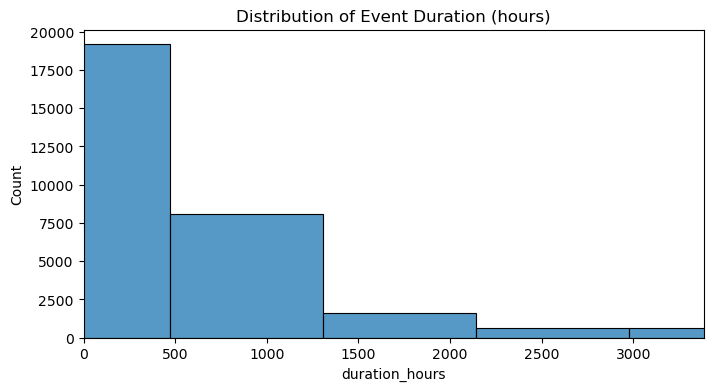

In [11]:
# Temporal distributions
if 'Reported_dt' in events_df.columns:
    events_df['reported_date'] = events_df['Reported_dt'].dt.date
    daily_counts = events_df.groupby('reported_date').size().reset_index(name='count')
    plt.figure(figsize=(14,4))
    plt.plot(daily_counts['reported_date'], daily_counts['count'])
    plt.xlim(daily_counts['reported_date'].min(), date.today())
    plt.title('Daily Reported Event Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

if 'duration_hours' in events_df.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(events_df['duration_hours'].dropna(), bins=50)
    plt.title('Distribution of Event Duration (hours)')
    plt.xlim(0, events_df['duration_hours'].quantile(0.95))
    plt.show()

if 'age_hours' in events_df.columns:
    print('Age (hours) stats:')
    print(events_df['age_hours'].describe())

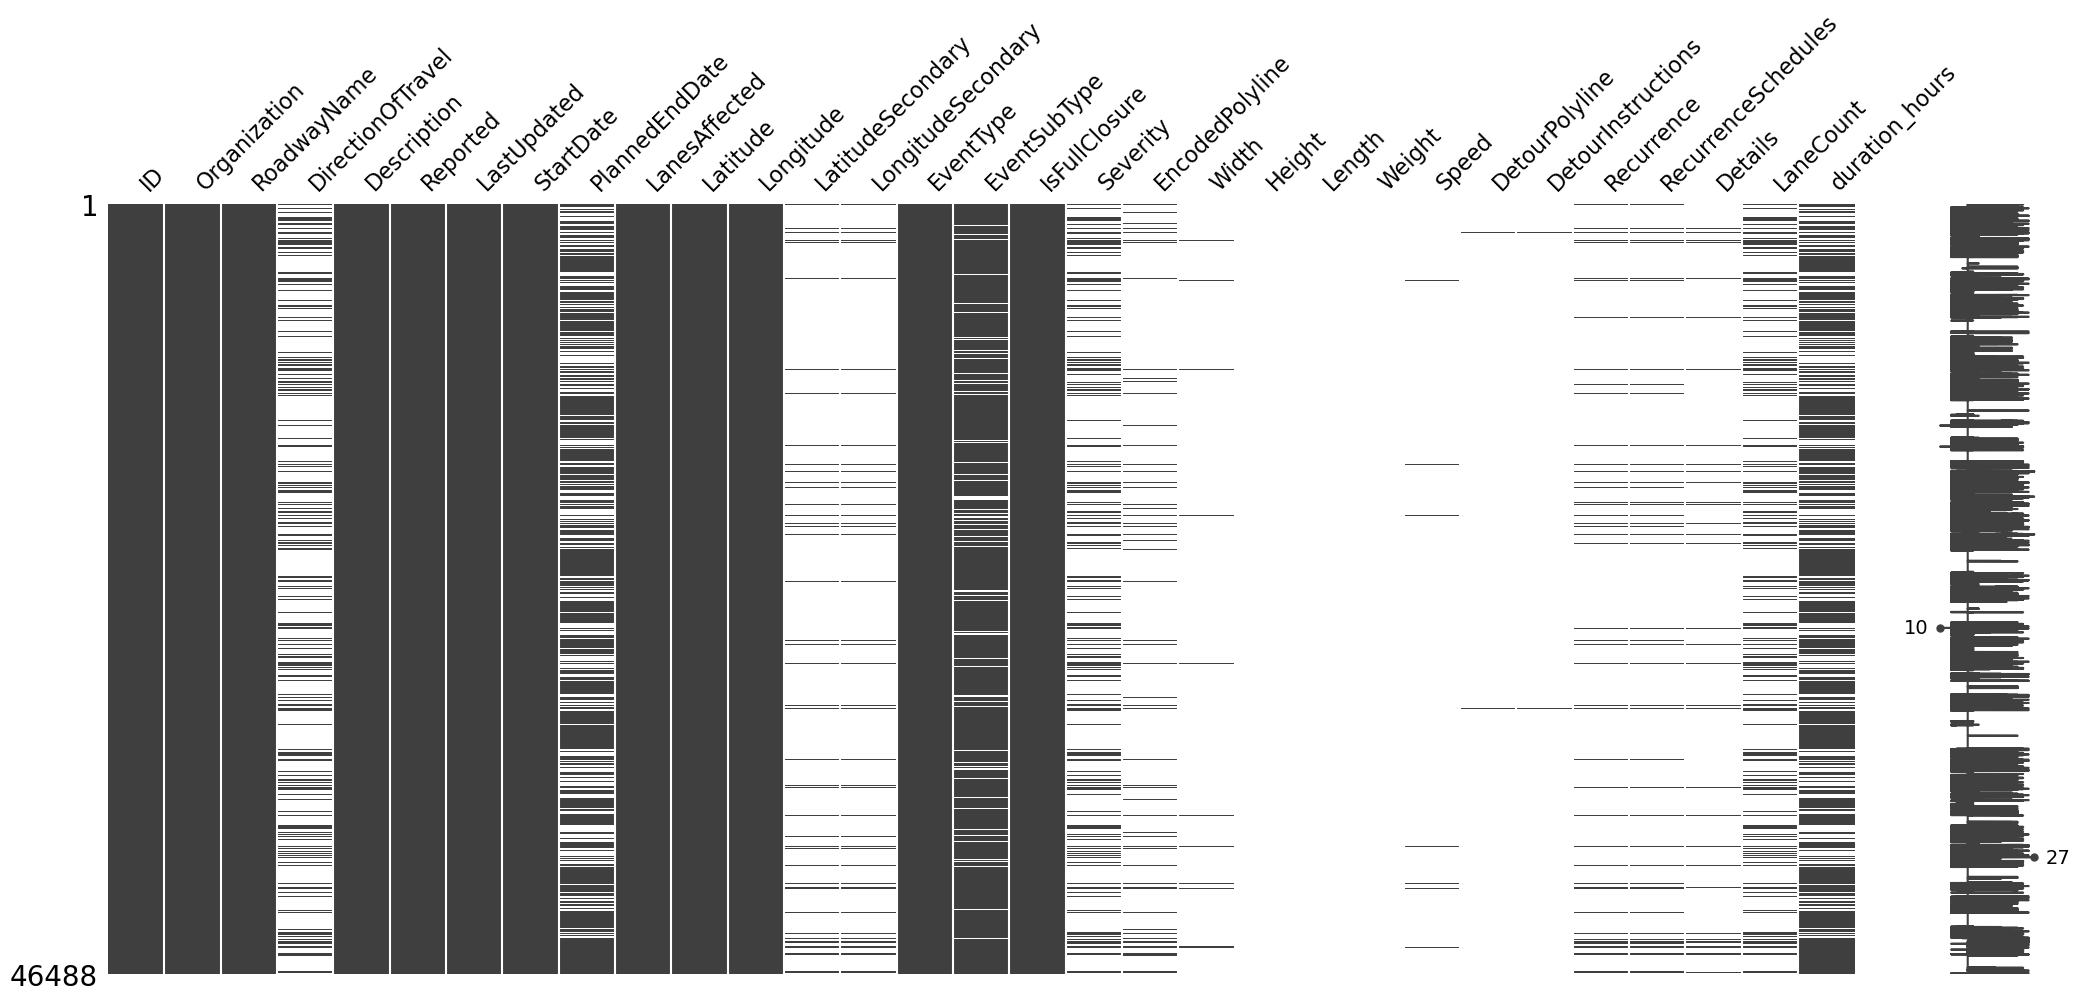

In [12]:
# Check missing patterns
msno.matrix(events_df)
plt.show()

In [13]:
events_df.columns

Index(['ID', 'Organization', 'RoadwayName', 'DirectionOfTravel', 'Description',
       'Reported', 'LastUpdated', 'StartDate', 'PlannedEndDate',
       'LanesAffected', 'Latitude', 'Longitude', 'LatitudeSecondary',
       'LongitudeSecondary', 'EventType', 'EventSubType', 'IsFullClosure',
       'Severity', 'EncodedPolyline', 'Width', 'Height', 'Length', 'Weight',
       'Speed', 'DetourPolyline', 'DetourInstructions', 'Recurrence',
       'RecurrenceSchedules', 'Details', 'LaneCount', 'duration_hours'],
      dtype='object')

In [11]:
# drop cols not needed for analysis
# separate events_df by event type and save to parquet files
# write each subset to parquet (fast & compressed)
out_dir = Path('../database')
out_dir.mkdir(parents=True, exist_ok=True)
event_groups = events_df.groupby("EventType", dropna=False)
for etype, df_sub in event_groups:
    # safe = ''.join(ch if ch.isalnum() else '_' for ch in str(etype))[:40]
    # print(safe, etype)
    if etype == "accidentsAndIncidents":
        cols_to_drop = ['EventType','LatitudeSecondary', 'LongitudeSecondary', 'EncodedPolyline','Width', 'Height', 'Length', 'Weight',
       'Speed', 'DetourPolyline', 'DetourInstructions','PlannedEndDate','Recurrence','RecurrenceSchedules','LanesAffected']
    else:
        cols_to_drop = ['EventType','LatitudeSecondary', 'LongitudeSecondary', 'EncodedPolyline','Width', 'Height', 'Length', 'Weight',
       'Speed', 'DetourPolyline', 'DetourInstructions']

    df_sub = df_sub.drop(columns=[c for c in cols_to_drop if c in df_sub.columns])
    df_sub.to_parquet(out_dir / f'events_{etype}.parquet', index=False)

    print('Saved:', f'events_{etype}.parquet', 'to', out_dir)

Saved: events_accidentsAndIncidents.parquet to ../database
Saved: events_closures.parquet to ../database
Saved: events_restrictionClass.parquet to ../database
Saved: events_roadwork.parquet to ../database
Saved: events_specialEvents.parquet to ../database


In [12]:
# Read back the parquet files
df_acc = pd.read_parquet('../database/events_accidentsAndIncidents.parquet')
df_clo = pd.read_parquet('../database/events_closures.parquet')
df_roa = pd.read_parquet('../database/events_roadwork.parquet')

In [13]:
print(len(df_acc), len(df_clo), len(df_roa))

15821 924 31212


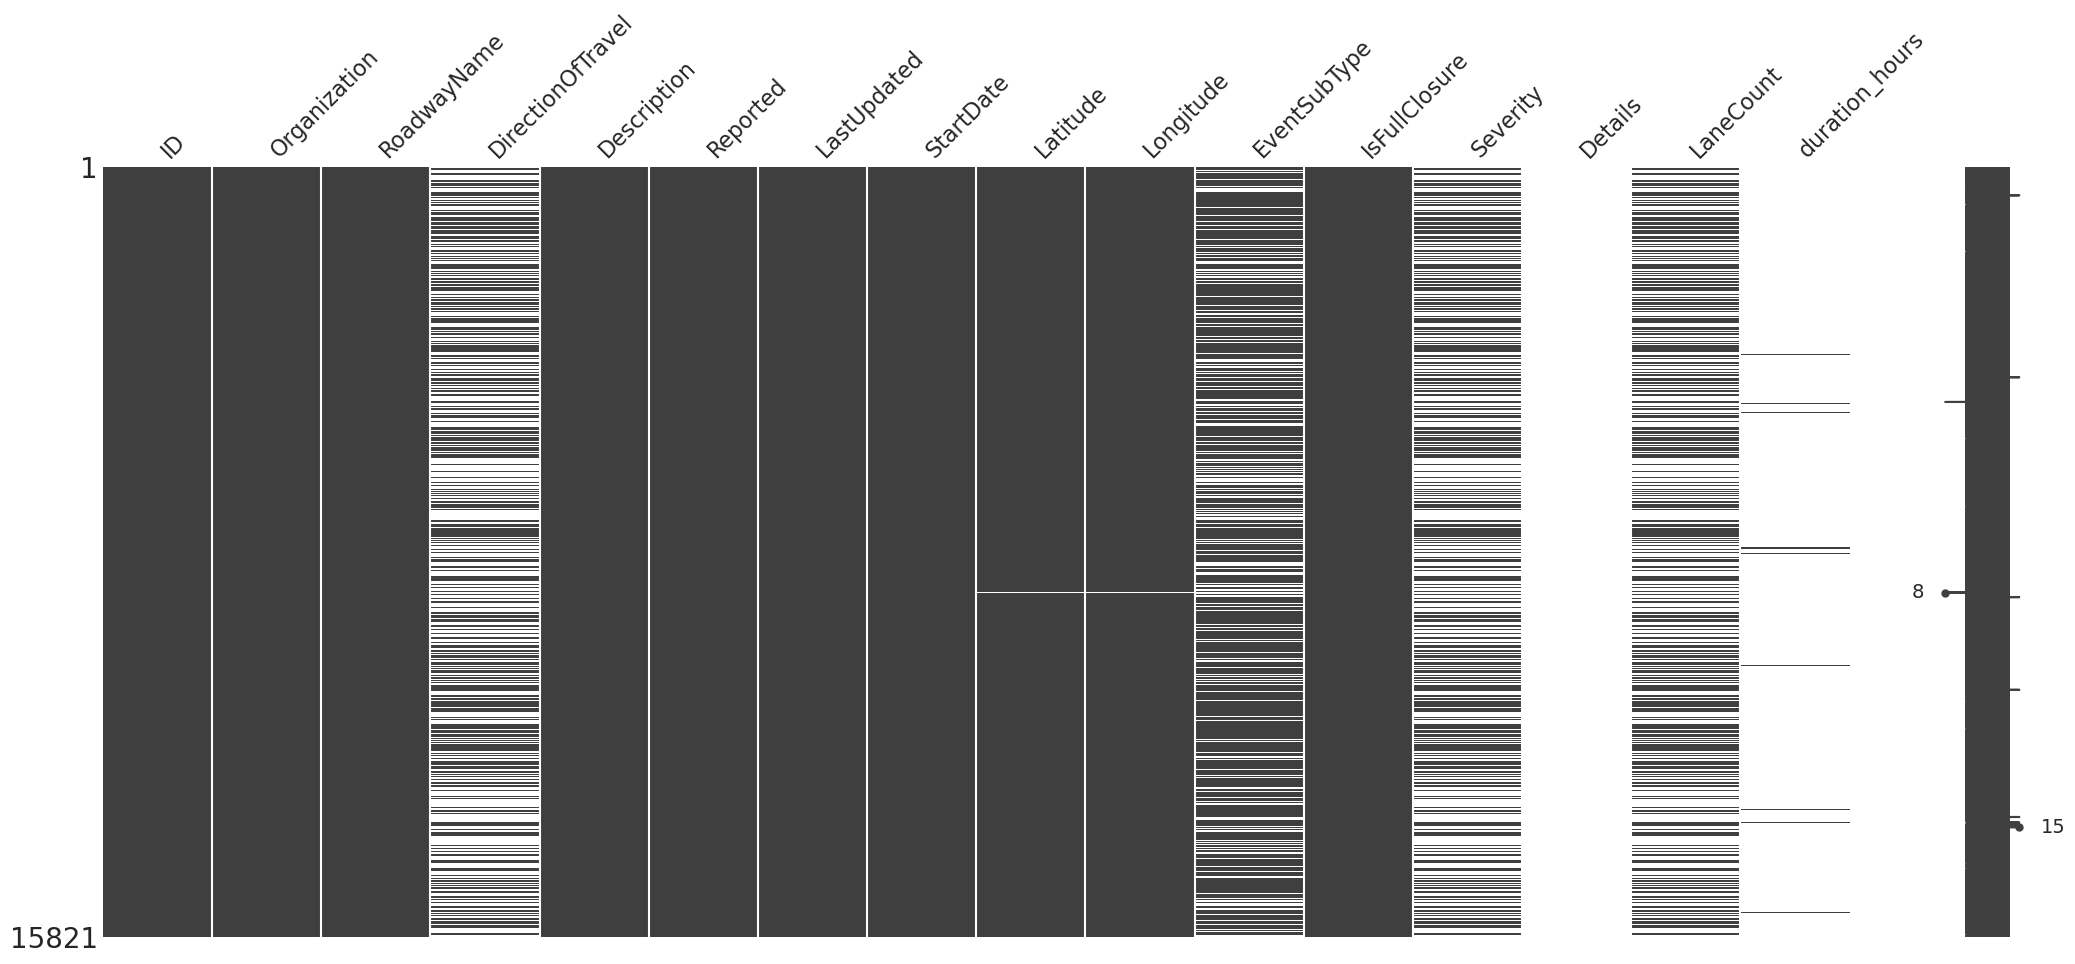

In [14]:

msno.matrix(df_acc)
plt.show()

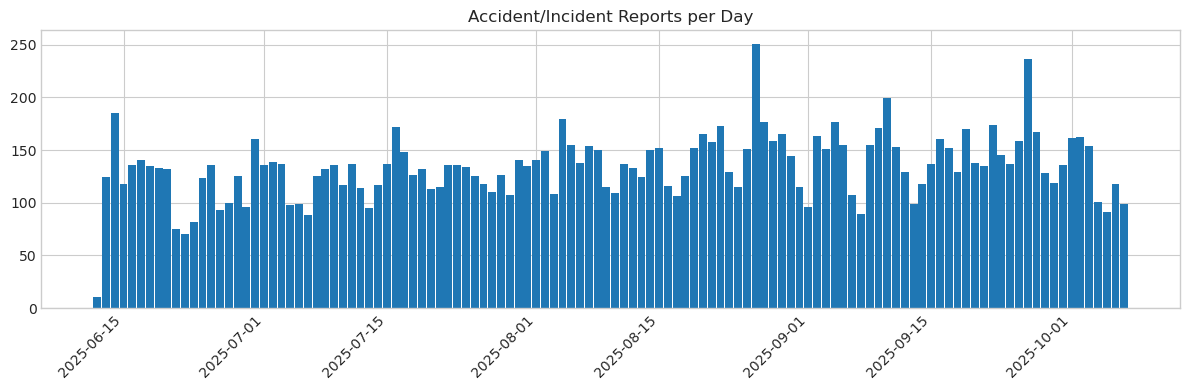

In [15]:
daily_counts = (df_acc
                .set_index('Reported')
                .resample('D')
                .size()
                .reset_index(name='count')
                .rename(columns={'Reported': 'reported_date'}))

plt.figure(figsize=(12,4))
plt.bar(daily_counts['reported_date'], daily_counts['count'], width=0.9)
plt.title('Accident/Incident Reports per Day')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

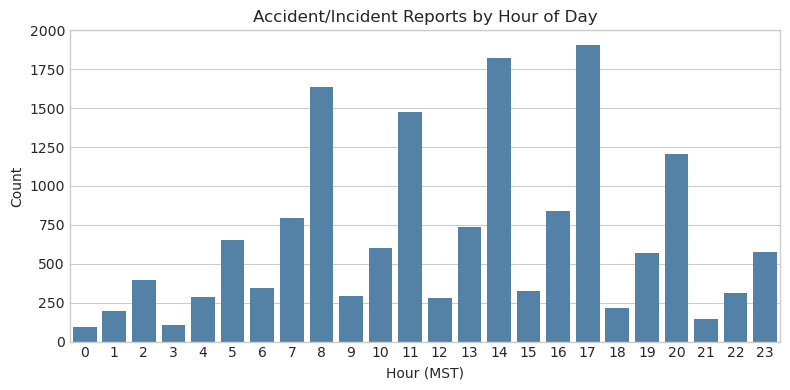

In [16]:
# Hour-of-day distribution (0-23)
phx_tz = ZoneInfo("America/Phoenix")
local_series = df_acc['Reported'].dt.tz_localize('UTC').dt.tz_convert(phx_tz)
hour_counts = local_series.dt.hour.value_counts().sort_index()

plt.figure(figsize=(8,4))
sns.barplot(x=hour_counts.index, y=hour_counts.values, color='steelblue')
plt.title('Accident/Incident Reports by Hour of Day')
plt.xlabel('Hour (MST)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

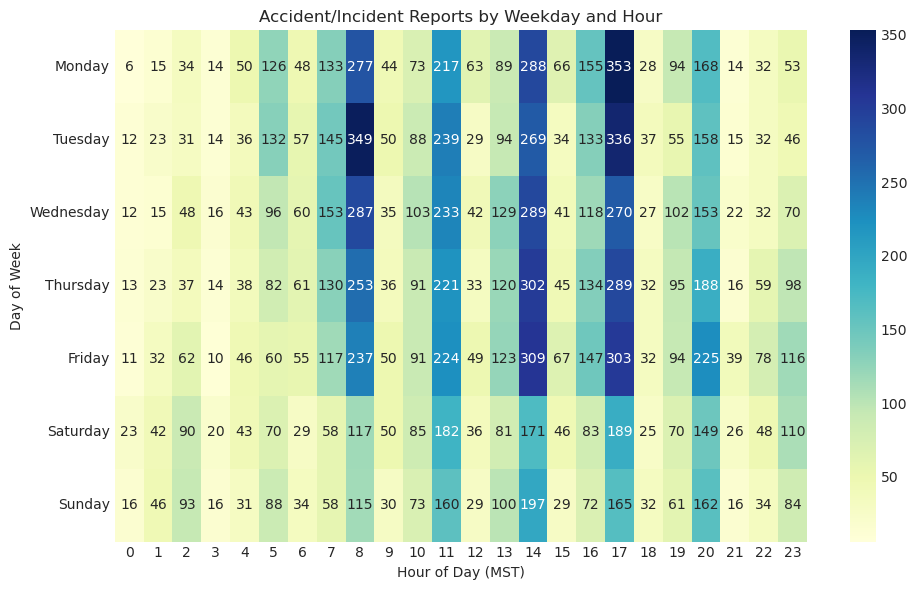

In [17]:
# a heatmap of accidents by weekday and hour
heatmap_data = (pd.DataFrame({
                    'weekday': local_series.dt.day_name(),
                    'hour': local_series.dt.hour
                })
                .value_counts()
                .reset_index(name='count'))
# Order weekdays
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data['weekday'] = pd.Categorical(heatmap_data['weekday'], categories=weekday_order, ordered=True)
heatmap_pivot = heatmap_data.pivot(index='weekday', columns='hour', values='count').sort_index()

plt.figure(figsize=(10,6))  
sns.heatmap(heatmap_pivot, cmap='YlGnBu', annot=True, fmt='g')
plt.title('Accident/Incident Reports by Weekday and Hour')
plt.xlabel('Hour of Day (MST)')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

## 5. Categorical Distributions & Cross Tabs


Top EventSubType:


EventSubType
None                       4136
AccidentIncident           3927
Crash on right shoulder    1318
C34Rshoulder                935
accident                    398
DebrisRshoulder             301
CrashLshoulder              253
C34Lshoulder                226
crashRlane                  215
debrisLshoulder             198
C34Rlane                    196
animalOnRoadway             194
C34exit                     166
vehicleOnFire               166
crashLlane                  131
Name: count, dtype: int64

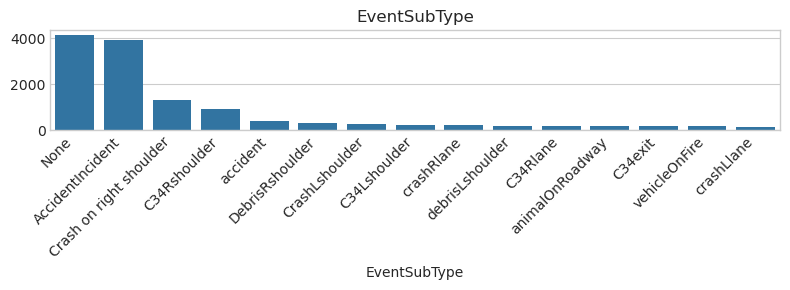


Top Severity:


Severity
None     8063
Minor    5794
None     1798
Major     166
Name: count, dtype: int64

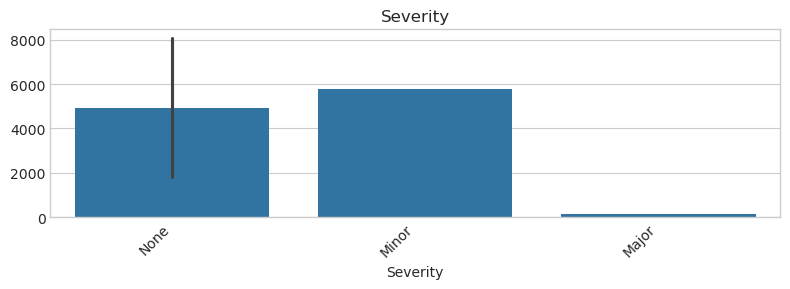


Top DirectionOfTravel:


DirectionOfTravel
None     8063
East     2373
West     2344
North    1535
South    1506
Name: count, dtype: int64

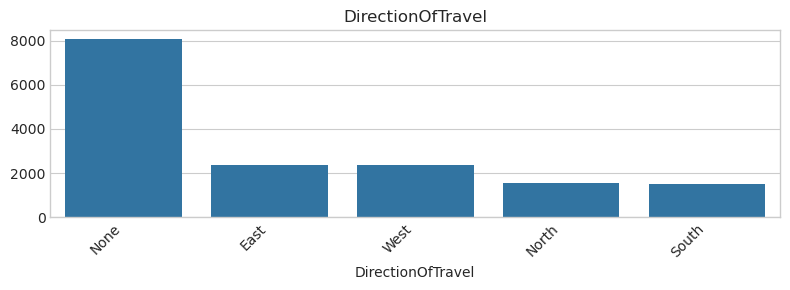


Top IsFullClosure:


IsFullClosure
0    15821
Name: count, dtype: int64

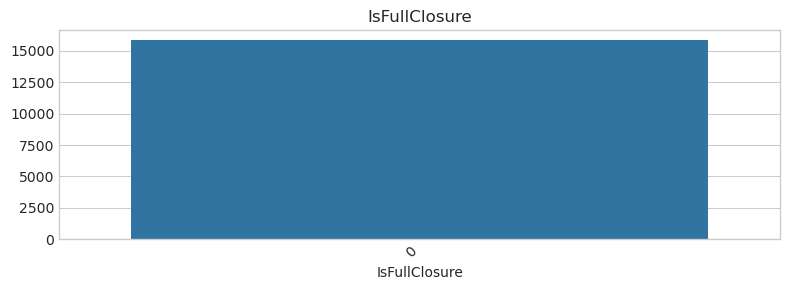

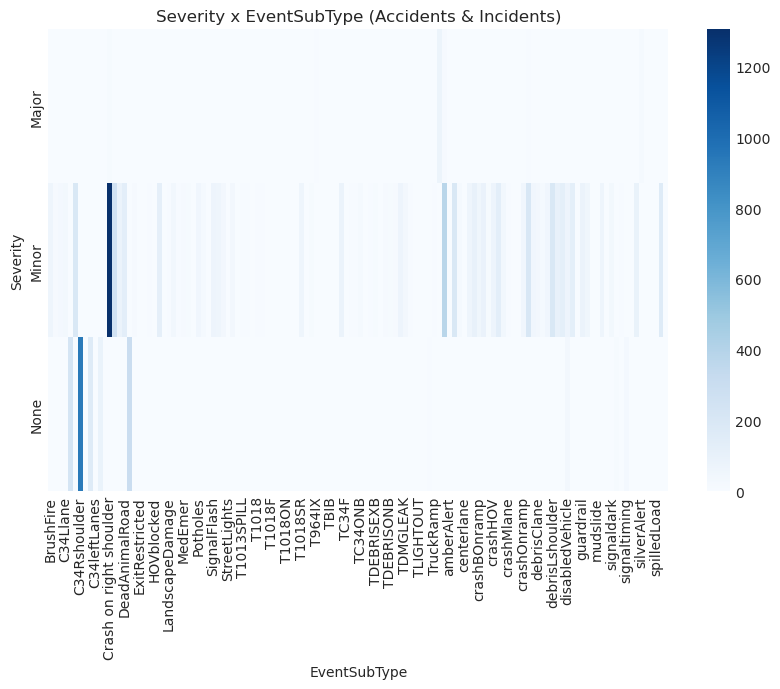

In [18]:
df = df_acc
cat_focus = ['EventSubType','Severity','DirectionOfTravel','IsFullClosure']
for c in cat_focus:
    if c in df.columns:
        vc = df[c].value_counts(dropna=False).head(15)
        print(f"\nTop {c}:")
        display(vc)
        plt.figure(figsize=(8,3))
        sns.barplot(x=vc.index.astype(str), y=vc.values)
        plt.title(c)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

# Crosstab example: Severity vs EventType
if set(['Severity','EventSubType']).issubset(df.columns):
    ct = pd.crosstab(df['Severity'], df['EventSubType'])
    plt.figure(figsize=(10,6))
    sns.heatmap(ct, annot=False, cmap='Blues', cbar=True)
    plt.title('Severity x EventSubType (Accidents & Incidents)')
    plt.show()

## 6. Spatial Preview
Scatter of primary & secondary coordinates (if available).

In [19]:
df_acc.columns

Index(['ID', 'Organization', 'RoadwayName', 'DirectionOfTravel', 'Description',
       'Reported', 'LastUpdated', 'StartDate', 'Latitude', 'Longitude',
       'EventSubType', 'IsFullClosure', 'Severity', 'Details', 'LaneCount',
       'duration_hours'],
      dtype='object')

In [20]:
df_acc.Description

0        Agency: Pima County Sheriff's DepartmentLocati...
1        Agency: Pima County Sheriff's DepartmentLocati...
2        Agency: Oro Valley Police DepartmentLocation: ...
3        Cross Streets: E SPEEDWAY BL AND N MOUNTAIN AV...
4        N 92ND AV/W VAN BUREN ST ,TOL - AccidentIncide...
                               ...                        
15816    Agency: Pima County Sheriff's DepartmentLocati...
15817    Address: 920 E TUCSON MARKETPLACE BL Open Time...
15818    E WILLIAMS FIELD RD / S ELLSWORTH RD MESA - Ac...
15819    Agency: Marana Police DepartmentLocation: 7047...
15820    S PACKARD DR / S RURAL RD                     ...
Name: Description, Length: 15821, dtype: object

In [21]:
df = df_acc
# df = df_acc.loc[df_acc['EventSubType']== 'AccidentIncident']

fig = px.scatter_map(df, lat='Latitude', lon='Longitude', color="Organization",
                     hover_data=['DirectionOfTravel','Description','Reported','RoadwayName','Details'],
                        center=dict(lat=df["Latitude"].mean(), lon=df["Longitude"].mean()), zoom=8)
fig.show()

In [24]:
df_acc.EventSubType.value_counts()[:15]

EventSubType
AccidentIncident           3927
Crash on right shoulder    1318
C34Rshoulder                935
accident                    398
DebrisRshoulder             301
CrashLshoulder              253
C34Lshoulder                226
crashRlane                  215
debrisLshoulder             198
C34Rlane                    196
animalOnRoadway             194
C34exit                     166
vehicleOnFire               166
crashLlane                  131
DeadAnimalRoad              130
Name: count, dtype: int64

In [36]:
df = df_clo
fig = px.scatter_map(df, lat='Latitude', lon='Longitude', color="EventSubType",
                     hover_data=['DirectionOfTravel','Description','Reported_dt','RoadwayName','Details'],
                        center=dict(lat=df["Latitude"].mean(), lon=df["Longitude"].mean()), zoom=8)
fig.show()

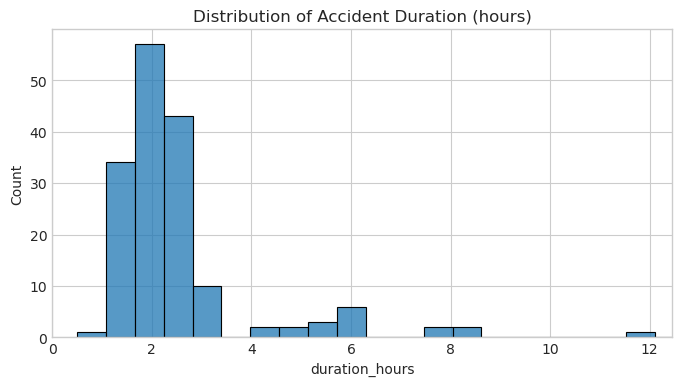

In [25]:
if 'duration_hours' in df_acc.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(df_acc['duration_hours'].dropna(), bins=50)
    plt.title('Distribution of Accident Duration (hours)')
    plt.xlim(0, df_acc['duration_hours'].quantile(0.95))
    plt.show()